# Compare two GEOS-Chem Classic datasets

## Overview of this Notebook

* Import dependencies
* Load data
* bpch vs bpch
* netCDF vs netCDF
* bpch vs netCDF
* Compare restart files (in development)
* Use new species categories and lumped species (in development)

To Do: 
* Discuss species lists with Matt Evans
* Fill in the rest of the category and species dictionaries (ideally the info would be in JSON files)
* Determine additional categories and their consitutents to include in benchmark (e.g. emissions, AOD)
* Create dictionary mapping between species and difference plot colorbar fixed range
* Create dictionary mapping binary units to netcdf units
* Put all dictionaries in JSON files in gcpy

## Import dependencies

In [27]:
import os
import numpy as np
import xarray as xr
import xbpch
import gcpy

# Enable auto-reloading modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [5]:
#------------ CUSTOMIZE AS NEEDED ---------------
# Shared high-level directory
testdir = '/Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test'

# Set directory to store plots
plotsdir = os.path.join(testdir,'plots')

# Define grid resolution (assume ref and dev are same grid resolution for now. Regridding not implemented yet.)
llres = '4x5'

# Define comparison type (choose one)
#comparison = 'bpch'
comparison = 'nc'
#comparison = 'bpch_vs_nc'

In [6]:
#-------------- BPCH ONLY ----------
# Edit file and directory strings as needed
if 'bpch' in comparison:
    
    # Always set bpch ref for bpch vs bpch or bpch vs nc
    refbpdir = 'bpch'
    refbpdiagfile = 'trac_avg.geosfp_4x5_benchmark.201607010000'
    refbpfile = os.path.join(testdir, refbpdir, refbpdiagfile)
    reftracerinfo = os.path.join(testdir,refbpdir,'tracerinfo.dat') 
    refdiaginfo = os.path.join(testdir,refbpdir,'diaginfo.dat')
    
    # Only set bpch dev is doing bpch vs bpch
    if comparison == 'bpch':
        # bpch dev
        devbpdir = 'bpch'
        devbpdiagfile = 'trac_avg.geosfp_4x5_benchmark.201607010000'
        devbpfile = os.path.join(testdir, devbpdir, devbpdiagfile)
        devtracerinfo = os.path.join(testdir,devbpdir,'tracerinfo.dat') 
        devdiaginfo = os.path.join(testdir,devbpdir,'diaginfo.dat')
        
        # Check paths
        gcpy.check_paths(refbpfile, devbpfile)
        gcpy.check_paths(reftracerinfo, devtracerinfo)
        gcpy.check_paths(refdiaginfo, devdiaginfo)

    print('Loading and processing bpch data...')

    # Read the bpch data
    refdata = xbpch.open_bpchdataset(refbpfile, tracerinfo_file=reftracerinfo, diaginfo_file=refdiaginfo)
    refdata = refdata.transpose('time','lev','lev_edge','lat', 'lon','nv') 
    refdata = gcpy.convert_bpch_names_to_netcdf_names(refdata)    
    if comparison == 'bpch':
        devdata = xbpch.open_bpchdataset(devbpfile, tracerinfo_file=devtracerinfo, diaginfo_file=devdiaginfo)
        devdata = devdata.transpose('time','lev','lev_edge','lat', 'lon','nv')
        devdata = gcpy.convert_bpch_names_to_netcdf_names(devdata)
        
    # Change the units for concentrations. If ppb or ppbv then change to mol/mol. Will need to do this for
    # other binary diagnostic units if they are not the same as netcdf. Ideally put the mapping in a dictionary.
    conc_units = ['ppb','ppbv']
    for var in refdata.data_vars:
        if refdata[var].units.strip() in conc_units:
            refdata[var].attrs['units'] = 'mol mol-1 dry'
            refdata[var].values = refdata[var].values * 1e-9
    if comparison == 'bpch':
        for var in refdata.data_vars:
            if devdata[var].units.strip() in conc_units:
                devdata[var].attrs['units'] = 'mol mol-1 dry'
                devdata[var].values = devdata[var].values * 1e-9

    print('Complete.')
    
    # Can now compare files if bpch vs bpch since all diagnostics in one file per version (no collections)
    if comparison == 'bpch':
        [cmnvars, cmnvars1D, cmcvars2D, cmnvars3D] = gcpy.compare_varnames(refdata, devdata)

In [7]:
#-------------- NETCDF ONLY ----------
# Edit file and directory strings as needed
if 'nc' in comparison:

    # Always set netcdf dev for nc vs nc or bpch vs nc
    devncdir = os.path.join(testdir,'nc')
    
    # Only set netcdf ref if doing nc vs nc
    if comparison == 'nc':
        refncdir = os.path.join(testdir,'nc')
        gcpy.check_paths(refncdir, devncdir)
        
    # If doing nc vs nc, compare files to see what collections are common in both versions
    if comparison == 'nc':
        reffiles = [k for k in os.listdir(refncdir) if '.nc' in k]
        devfiles = [k for k in os.listdir(devncdir) if '.nc' in k]
        common_files = [k for k in reffiles if k in devfiles]
        refonly_files = [k for k in reffiles if k not in devfiles]
        devonly_files = [k for k in devfiles if k not in reffiles]
        print('Common files: \n{}'.format(common_files))
        print('Ref only files: \n{}'.format(refonly_files))
        print('Dev only files: \n{}'.format(devonly_files))

Path 1 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/nc
Path 2 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/nc
Common files: 
['HEMCO_diagnostics.201607010000.nc', 'GEOSChem.StateChm.20160701_0000z.nc4', 'GEOSChem.StateMet.20160701_0000z.nc4', 'GEOSChem.Aerosols.20160701_0000z.nc4', 'GEOSChem.CloudConvFlux.20160701_0000z.nc4', 'GEOSChem.ConcAfterChem.20160701_0000z.nc4', 'GEOSChem.JValuesLocalNoon.20160701_0000z.nc4', 'GEOSChem.DryDep.20160701_0000z.nc4', 'GEOSChem.JValues.20160701_0000z.nc4', 'GEOSChem.WetLossConv.20160701_0000z.nc4', 'GEOSChem.LevelEdgeDiags.20160701_0000z.nc4', 'GEOSChem.Budget.20160701_0000z.nc4', 'GEOSChem.SpeciesConc.20160701_0000z.nc4', 'GEOSChem.WetLossLS.20160701_0000z.nc4', 'GEOSChem.AerosolMass.20160701_0000z.nc4', 'GEOSChem.ProdLoss.20160701_0000z.nc4']
Ref only files: 
[]
Dev only files: 
[]


## Compare diagnostics

In [8]:
# Three options. Edit ref and dev strings as needed for use in plotting:

#--------------------- Option 1: bpch vs bpch -----------------------
if 'bpch' in comparison:
    refstr='12.0.3'
    if comparison == 'bpch':
        devstr='12.1.0'

#--------------------- Option 2: nc vs nc ----------------------
if 'nc' in comparison:
    devstr='12.1.0'
    if comparison == 'nc':
        refstr='12.0.3'

#--------------------- Option 3: bpch vs nc ----------------------
if comparison == 'bpch_vs_nc':
    refstr='Binary diagnostic, 12.1.0'
    devstr='Netcdf diagnostic, 12.1.0'
    
print('Ref: {}'.format(refstr))
print('Dev: {}'.format(devstr))

Ref: 12.0.3
Dev: 12.1.0


### Species concentrations

In [9]:
#------------ NetCDF diagnostics: get collection ---------------
# Edit day and time as needed
if 'nc' in comparison:
    day = '20160701'
    time = '0000'
    collection = 'SpeciesConc'
    devdata = gcpy.get_collection_data(devncdir, collection, day, time)
    if comparison == 'nc':
        refdata = gcpy.get_collection_data(refncdir, collection, day, time)
    
    # If bpch vs nc then refdata will have already been defined, so can now do a comparison no matter what
    [cmnvars, cmnvars1D, cmnvars2D, cmnvars3D] = gcpy.compare_varnames(refdata, devdata)

189 common variables
0 variables in ref only
0 variables in dev only
All variables have same dimensions in ref and dev


In [10]:
#------------ CUSTOMIZE VARIABLE LIST DEFINED IN THIS CELL ---------------

# All species
#desc='spc_conc'
#varlist = [k for k in cmnvars if 'SpeciesConc_' in k]

# Subset of species
desc='Dust'
varlist = [k for k in cmnvars if 'DST' in k and 'SpeciesConc' in k]

# Single species
#desc='Ozone'
#varlist = ['SpeciesConc_O3']

print('{} variables found'.format(len(varlist)))
varlist

4 variables found


['SpeciesConc_DST1',
 'SpeciesConc_DST2',
 'SpeciesConc_DST3',
 'SpeciesConc_DST4']

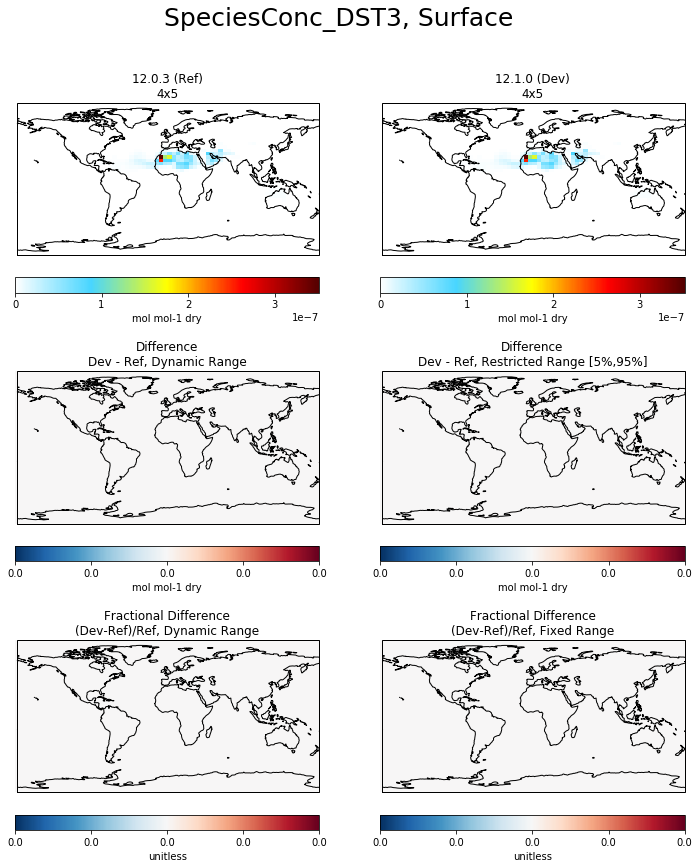

In [8]:
# Surface - quick plot
gcpy.compare_single_level( refdata, refstr, devdata, devstr, varlist=['SpeciesConc_DST3'])

In [9]:
# Surface - PDF
pdfname = os.path.join(plotsdir,'{}_surface_{}_diag.pdf'.format(desc,comparison))
gcpy.compare_single_level( refdata, refstr, devdata, devstr, varlist=varlist, savepdf=True, pdfname=pdfname )
gcpy.add_bookmarks_to_pdf( pdfname, varlist, remove_prefix='SpeciesConc_')


Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/Dust_surface_nc_diag.pdf for 4 variables
0 1 2 3 

(72, 46, 72)


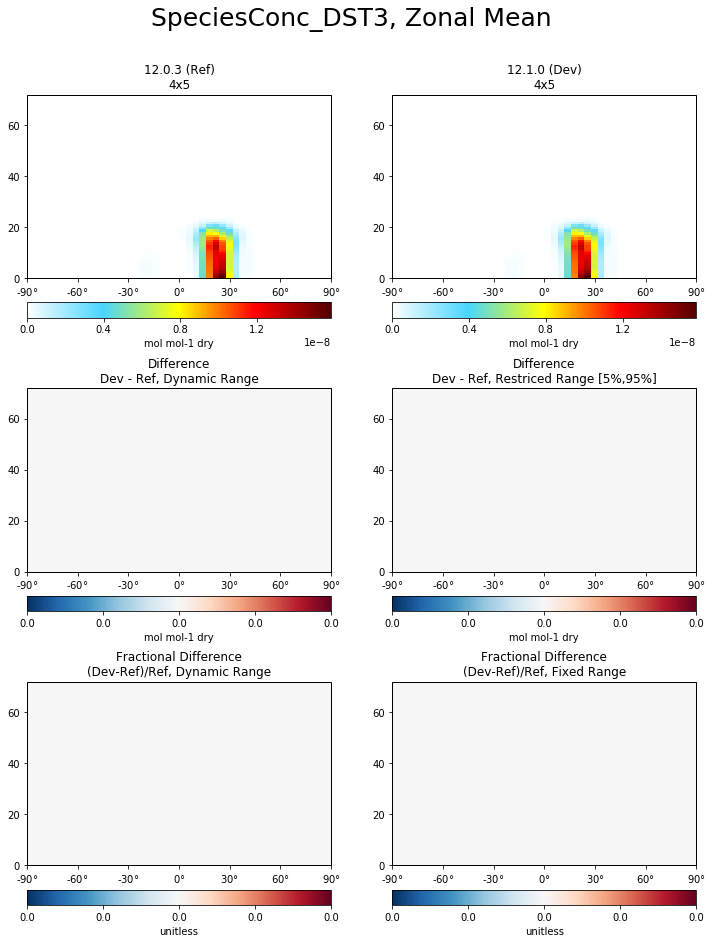

In [10]:
# Zonal mean - quick plot
gcpy.compare_zonal_mean( refdata, refstr, devdata, devstr, varlist=['SpeciesConc_DST3'])

In [11]:
# Zonal mean - PDF
pdfname = os.path.join(plotsdir,'{}_zonalmean_{}_diag.pdf'.format(desc, comparison))
gcpy.compare_zonal_mean( refdata, refstr, devdata, devstr, varlist=varlist, savepdf=True, pdfname=pdfname )
gcpy.add_bookmarks_to_pdf( pdfname, varlist, remove_prefix='SpeciesConc_')


Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/Dust_zonalmean_nc_diag.pdf for 4 variables
0 (72, 46, 72)
1 (72, 46, 72)
2 (72, 46, 72)
3 (72, 46, 72)


### Emissions

In [12]:
#------------ NetCDF diagnostics only ---------------
# Edit day and time as needed
if 'nc' in comparison:
    day = '20160701'
    time = '0000'
    collection = 'Emissions'
    devncdata = gcpy.get_collection_data(devncdir, collection, day, time)
    devdata = devncdata
    if comparison == 'nc':
        refncdata = gcpy.get_collection_data(refncdir, collection, day, time)
        refdata = refncdata
        
    # If bpch vs nc then refdata will have already been defined, so can now do a comparison no matter what
    [cmnvars, cmnvars1D, cmnvars2D, cmnvars3D] = gcpy.compare_varnames(refdata, devdata)

131 common variables
0 variables in ref only
0 variables in dev only
All variables have same dimensions in ref and dev


In [13]:
#------------ CUSTOMIZE VARIABLE LIST DEFINED IN THIS CELL ---------------

# All emissions
#desc='emissions'
#varlist = [k for k in cmnvars if 'Emis' in k]

# Subset of emissions
desc='EmisACET'
varlist = [k for k in cmnvars if 'EmisACET' in k]

# Single emission
#desc='EmisACETAnthro'
#varlist = ['EmisACET_Anthro']

print('{} variables found'.format(len(varlist)))
varlist

9 variables found


['EmisACET_Anthro',
 'EmisACET_BioBurn',
 'EmisACET_Biofuel',
 'EmisACET_Biogenic',
 'EmisACET_DirectBio',
 'EmisACET_MethylBut',
 'EmisACET_Monoterp',
 'EmisACET_Ocean',
 'EmisACET_Total']

In [14]:
devdata['EmisACET_Anthro'].units

'atomsC/cm2/s'

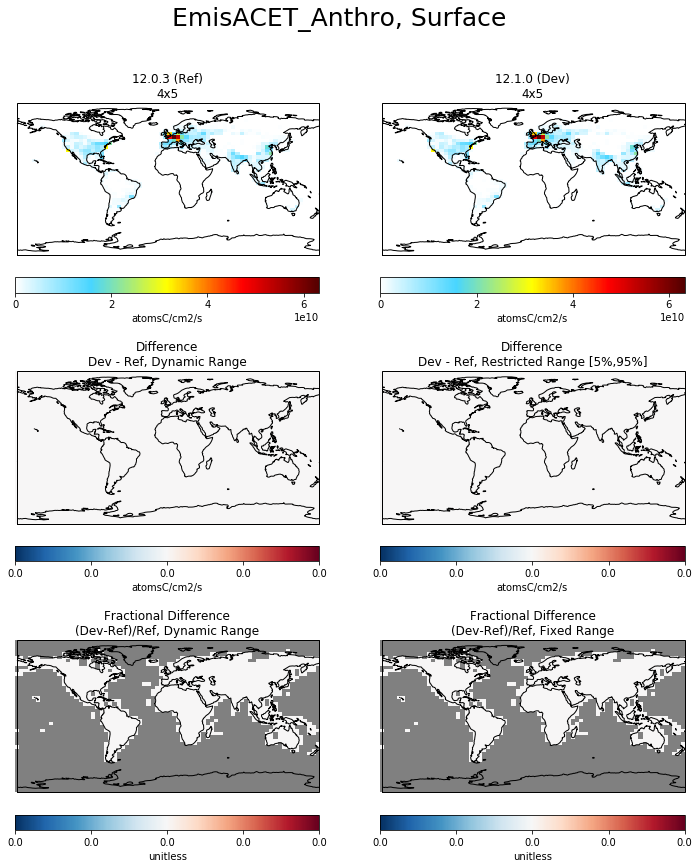

In [15]:
# Surface - quick plot, one emissions
gcpy.compare_single_level( refdata, refstr, devdata, devstr, varlist=['EmisACET_Anthro'])

# Note: If you get an error that units do not match then you need to update the bpch units change earlier in
# this notebook (same cell as data load). Show units with refdata[varname].units and devdata[varname].units.
# See also guide for inspecting binary diagnostic units further down in notebook.

In [16]:
# Surface - PDF, all emissions
pdfname = os.path.join(plotsdir,'{}_surface_{}_diag.pdf'.format(desc, comparison))
gcpy.compare_single_level( refdata, refstr, devdata, devstr, varlist=varlist, savepdf=True, pdfname=pdfname )
gcpy.add_bookmarks_to_pdf( pdfname, varlist, remove_prefix='Emis')


Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/EmisACET_surface_nc_diag.pdf for 9 variables
0 1 2 3 4 5 6 7 8 

### AOD

In [17]:
# TODO

### If bpch vs nc, inspect binary diagnostic units if bpch vs netcdf

In [18]:
# Print all unique units in bpch datasets
# unitstrs = []
# for var in refbpdata.data_vars:
#     if refbpdata[var].units.strip() not in unitstrs:
#         unitstrs.append(refbpdata[var].units.strip())
# unitstrs

In [19]:
# Look for instances of certain units in bpch and netcdf datasets
# unitstr = 'kg/m2s'

# bpvarnames = []
# for var in refbpdata.data_vars:
#     if devbpdata[var].units.strip() == unitstr:
#         bpvarnames.append(var)
# bpvarnames

# ncvarnames = []
# for var in refbpdata.data_vars:
#     if devncdata[var].units.strip() == unitstr:
#         ncvarnames.append(var)
# ncvarnames

## Compare restart files (in development)

In [20]:
#reffile_rst = os.path.join(refbpdir,'GEOSChem_restart.201607010000.nc')
#devfile_rst = os.path.join(devbpdir,'GEOSChem_restart.201607010000.nc')
#gcpy.check_paths(reffile_rst, devfile_rst)

In [21]:
#refdata_rst = xr.open_dataset(reffile_rst)
#devdata_rst = xr.open_dataset(devfile_rst)
#[commonvars, commonvars2D, commonvars3D] = gcpy.compare_varnames(refdata_rst, refstr, devdata_rst, devstr)

In [22]:
#gcpy.get_stats(refdata_rst, refstr, devdata_rst, devstr, 'SPC_CFC11')

In [23]:
#compare_zonal_mean( refdata_rst, refstr, devdata_rst, devstr, llres, varlist=['SPC_O3'] )

In [24]:
#compare_single_level( refdata_rst, refstr, devdata_rst, devstr, llres, varlist=['SPC_O3'] )

## New species categories and lumped variables (in development)

NOTE: More discussion is needed to finalize these lists. Several species are not currently outputted and several species that are outputted are not listed here.

Primary checks: O3, NOx (NO+NO2), CO, OH, AOD

Aerosols: SO4, NIT, NH4, DST1, DST2, DST3, DST3, OCPI, OCPO, BCPI, BCPO, SALC, SALA, SO2s, SOA,

Nitrogen: NO, NO2, NO3, N2O5, HNO2, HNO4, CH3O2NO2, HNO3, PAN, PPN, IPMN, N2O, NH4, NH3, NIT, 
NOx, NOy (gas), NOy (gas+aerosol), NHx

ROy: OH, HO2, RO2 (sum all peroxy), O(1D), H2O2, H, H2, H2O, O(3P)

Primary Organics
  HCs: CH4, C2H6, C2H4, C3H8, PRPE, ALK4, BENZ, TOL, XYLE, ISOP, Monoterpenes
  Others: GLYX, HCOOH, MAP, MBO, MOH, RCHO

Secondary Organics
  Ketone: ACET, MEK, MVK
  Aldehydes: ALD2, CH2O, HPALD
  Peroxides: CH3OOH, ISOPOOH
  Nitrates: ISOPN
  Epoxides: IEPOX
  Acids: ACTA
  Alcohols: MOH, EtOH 

Sulfur: SO2, DMS, OCS, SO4, SOx (SO2+SO4)

Iodine: I, I2, ICl, IBr, IO, HOI, HI, INO2, INO3, OIO, IxOy, AERI+ISALA+ISALC
CH3I, CH2I2, CH2ICl, CH2IBr, IOy (I+IO+OIO+x*IxOy), 
Iy (I+ 2*I2+ ICl+ IBr+ HOI+ HI+ INO2+ INO3+ OIO+ x*IxOy+AERI+ISALA+ISALC)

Bromine: Br, BrO, Br2, BrCl, HOBr, HBr, BrNO2, BrNO3, CH3Br, CH2Br2, CHBr3,
BrOx(Br+BrO), Bry(Br, BrO, Br2, BrCl, HOBr, HBr, BrNO2, BrNO3)

Chlorine: Cl, ClO, Cl2, HOCl, HCl, Cl2O2, ClOO, ClNO2, ClNO3, OClO,
CCl4, CH3Cl, CH2Cl2, CH3CCl3, SUM(CFC11, CFC12, CFC113, CFC114, CFC115),
SUM(H1211, H1302, H2402), SUM(HCFC123, HCFC141b, HCFC142b),
ClOx (Cl+ClO), Cly (Cl, ClO, 2*Cl2, HOCl, HCl, Cl2O2, ClOO, ClNO2, ClNO3, OClO)


In [49]:
# Load species conc collection
devncdir = os.path.join(testdir,'nc')
refncdir = os.path.join(testdir,'nc')
gcpy.check_paths(refncdir, devncdir)
day = '20160701'
time = '0000'
collection = 'SpeciesConc'
refdata = gcpy.get_collection_data(refncdir, collection, day, time)
devdata = gcpy.get_collection_data(devncdir, collection, day, time)
spc_units = refdata['SpeciesConc_O3'].units 

Path 1 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/nc
Path 2 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/nc


In [50]:
refstr = '12.1.0'
devstr = '12.1.0'
[commonvars, commonvars1D, commonvars2D, commonvars3D] = gcpy.compare_varnames(refdata, devdata)

189 common variables
0 variables in ref only
0 variables in dev only
All variables have same dimensions in ref and dev


In [51]:
# Print list of species in file (skip non-species variables)
spcvars = [k for k in commonvars if 'SpeciesConc' in k]
print('{} species:'.format(len(spcvars)))
print([k.replace('SpeciesConc_','') for k in spcvars])

183 species:
['ACET', 'ACTA', 'AERI', 'ALD2', 'ALK4', 'ASOA1', 'ASOA2', 'ASOA3', 'ASOAN', 'ASOG1', 'ASOG2', 'ASOG3', 'BCPI', 'BCPO', 'BENZ', 'Br', 'Br2', 'BrCl', 'BrNO2', 'BrNO3', 'BrO', 'BrSALA', 'BrSALC', 'C2H6', 'C3H8', 'CCl4', 'CFC11', 'CFC113', 'CFC114', 'CFC115', 'CFC12', 'CH2Br2', 'CH2Cl2', 'CH2I2', 'CH2IBr', 'CH2ICl', 'CH2O', 'CH3Br', 'CH3CCl3', 'CH3Cl', 'CH3I', 'CH4', 'CHBr3', 'CHCl3', 'CO', 'Cl', 'Cl2', 'Cl2O2', 'ClNO2', 'ClNO3', 'ClO', 'ClOO', 'DHDN', 'DMS', 'DST1', 'DST2', 'DST3', 'DST4', 'EOH', 'ETHLN', 'GLYC', 'GLYX', 'H1211', 'H1301', 'H2402', 'H2O', 'H2O2', 'HAC', 'HBr', 'HC187', 'HCFC123', 'HCFC141b', 'HCFC142b', 'HCFC22', 'HCOOH', 'HCl', 'HI', 'HNO2', 'HNO3', 'HNO4', 'HOBr', 'HOCl', 'HOI', 'HONIT', 'HPALD', 'I', 'I2', 'I2O2', 'I2O3', 'I2O4', 'IBr', 'ICl', 'IEPOXA', 'IEPOXB', 'IEPOXD', 'IMAE', 'INDIOL', 'INO', 'IO', 'IONITA', 'IONO', 'IONO2', 'IPMN', 'ISALA', 'ISALC', 'ISN1', 'ISN1OA', 'ISN1OG', 'ISOA1', 'ISOA2', 'ISOA3', 'ISOG1', 'ISOG2', 'ISOG3', 'ISOP', 'ISOPNB', 'I

In [72]:
x = gcpy.benchmark.get_species_categories()
#x

In [74]:
y = gcpy.benchmark.get_lumped_species_definitions()
#y

In [78]:
gcpy.benchmark.archive_species_categories('/Users/lizzielundgren/gc')

Archiving benchmark_categories.json in /Users/lizzielundgren/gc


In [80]:
gcpy.benchmark.archive_lumped_species_definitions('/Users/lizzielundgren/gc')

Archiving lumped_species.json in /Users/lizzielundgren/gc


In [28]:
# Create dictionary defining constituents of each new species group to sum values for
spcdict = {'NOy': (('SpeciesConc_NO',1),('SpeciesConc_NO2',1))}
# Add more later

In [29]:
# Add the summed species variables to the ref and dev datasets
for key in spcdict:
    refdata = gcpy.add_species_to_dataset(refdata, key, spcdict[key], spc_units, overwrite=True)
    devdata = gcpy.add_species_to_dataset(devdata, key, spcdict[key], spc_units, overwrite=True)

In [30]:
# Create dictionary defining constituents of each category to create files for
categorydict = {'Primary': ('SpeciesConc_O3', 'SpeciesConc_CO','NOy'),
               'PrimaryOrgancsHCs': ('SpeciesConc_ALK4', 'SpeciesConc_ISOP', 'SpeciesConc_PRPE',
                                    'SpeciesConc_C3H8', 'SpeciesConc_C2H6', 'SpeciesConc_BENZ',
                                    'SpeciesConc_TOLU', 'SpeciesConc_XYLE', 'SpeciesConc_CH4')
               }
# Add more later

In [31]:
# Make a PDF for each category
for catkey in categorydict:
    pdfname = os.path.join(plotsdir,'{}_Surface_ncdiag.pdf'.format(catkey))
    gcpy.compare_single_level(refdata, refstr, devdata, devstr, llres, varlist=categorydict[catkey], ilev=0,
                     savepdf=True, pdfname=pdfname )
    gcpy.add_bookmarks_to_pdf(pdfname, categorydict[catkey], remove_prefix='SpeciesConc_')


Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/Primary_Surface_ncdiag.pdf for 3 variables
0 1 2 
Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/PrimaryOrgancsHCs_Surface_ncdiag.pdf for 9 variables
0 1 2 3 4 5 6 7 8 

README                          benchmark_1mon_sandbox.ipynb
benchmark_1mon_prototype.ipynb


/Users/lizzielundgren/gc/python/gcpy/gcpy


In [47]:
pwd

'/Users/lizzielundgren'

In [25]:
lumped_species = np.genfromtxt('./lumped_species.json')

ValueError: Some errors were detected !
    Line #2 (got 3 columns instead of 2)
    Line #53 (got 1 columns instead of 2)
    Line #54 (got 1 columns instead of 2)
    Line #55 (got 3 columns instead of 2)
    Line #66 (got 1 columns instead of 2)
    Line #67 (got 1 columns instead of 2)
    Line #68 (got 3 columns instead of 2)
    Line #107 (got 1 columns instead of 2)
    Line #108 (got 1 columns instead of 2)
    Line #109 (got 3 columns instead of 2)
    Line #147 (got 1 columns instead of 2)
    Line #148 (got 1 columns instead of 2)
    Line #149 (got 3 columns instead of 2)
    Line #154 (got 1 columns instead of 2)
    Line #155 (got 1 columns instead of 2)
    Line #156 (got 3 columns instead of 2)
    Line #170 (got 1 columns instead of 2)
    Line #171 (got 1 columns instead of 2)
    Line #172 (got 3 columns instead of 2)
    Line #174 (got 1 columns instead of 2)
    Line #175 (got 1 columns instead of 2)
    Line #176 (got 3 columns instead of 2)
    Line #185 (got 1 columns instead of 2)
    Line #186 (got 1 columns instead of 2)
    Line #187 (got 3 columns instead of 2)
    Line #194 (got 1 columns instead of 2)
    Line #195 (got 1 columns instead of 2)
    Line #196 (got 3 columns instead of 2)
    Line #208 (got 1 columns instead of 2)
    Line #209 (got 1 columns instead of 2)
    Line #210 (got 3 columns instead of 2)
    Line #212 (got 1 columns instead of 2)
    Line #213 (got 1 columns instead of 2)
    Line #214 (got 3 columns instead of 2)
    Line #218 (got 1 columns instead of 2)
    Line #219 (got 1 columns instead of 2)